In [1]:
# %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import mne
np.random.seed(100)

# Example 
$y = 0.5 + 1.2 x + \epsilon$, where $\epsilon \sim N(0, \sigma^2)$

In [2]:
# function that calculates r2 as a function of sigma while keeping other coefficients constant
def r2(sig):
    
    x= np.arange(1,10, step = 0.1)
    y = 0.5 + 1.2*x + np.random.normal(0,sig, len(x))
    data = pd.DataFrame({'x':x, 'y':y})
    model = ols('y ~ x',data).fit()
    r2 = model.rsquared
    r2_adjusted = model.rsquared_adj
    return r2,r2_adjusted


Text(0, 0.5, 'r2')

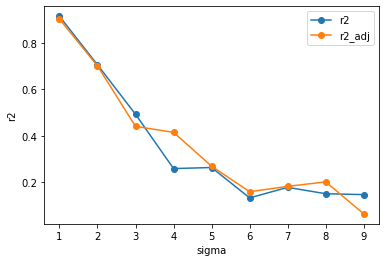

In [3]:
# R2 gets smaller as the noise level goes up 
sig_vec = np.arange(1,10, step = 1)
r2_vec = [r2(sig)[0] for sig in sig_vec]
r2_adjusted = [r2(sig)[1] for sig in sig_vec]
plt.plot(sig_vec, r2_vec,  '-o', label = 'r2')
plt.plot(sig_vec, r2_adjusted,  '-o', label = 'r2_adj')
plt.legend()
plt.xlabel('sigma')
plt.ylabel('r2')

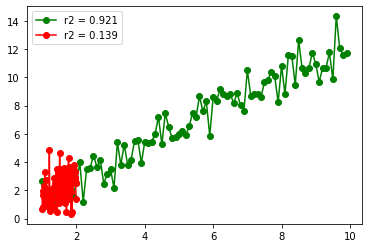

In [4]:
# R^2 can get close to 1 when the range of X increases
sig = 0.9
x1= np.arange(1,10, step = 0.1)
y1 = 0.5 + 1.2*x1 + np.random.normal(0,sig, len(x1))
data = pd.DataFrame({'x1':x1, 'y1':y1})
model = ols('y1 ~ x1', data).fit()
r2_long = model.rsquared


sig = 0.9
x2= np.arange(1,2, step = 0.01)
y2 = 0.5 + 1.2*x2 + np.random.normal(0,sig, len(x2))
data = pd.DataFrame({'x2':x2, 'y2':y2})
model = ols('y2 ~ x2', data).fit()
r2_short = model.rsquared

plt.plot(x1, y1, color = 'green', label = 'r2 = ' + str(round(r2_long,3)), marker = 'o')
plt.plot(x2, y2,color = 'red', label = 'r2 = ' + str(round(r2_short,3)), marker = 'o')
plt.legend()


0.9386828027861313 0.9999999360814321


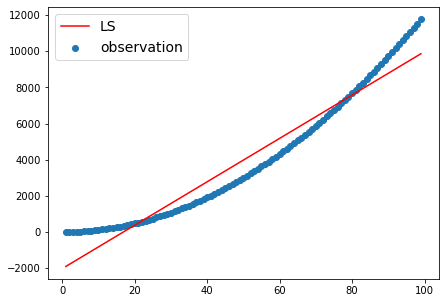

In [5]:
# Ok to compare different transformations of x
# y is fixed 
x= np.arange(1,100, step = 1)
y = 0.5 + 1.2*pow(x,2) + np.random.normal(0,sig, len(x))

data = pd.DataFrame({'x':x, 'y':y, 'x_squared':pow(x,2)})
model_untransformed = ols('y ~ x',data).fit()
r2_untransformed = model_untransformed.rsquared


alpha_est = model_untransformed.params['Intercept']
b_est = model_untransformed.params['x']

fig = plt.figure(figsize = (7,5))
ax = plt.subplot(111)

ax.scatter(x,y, label = 'observation')
ax.plot(x, alpha_est + b_est*x, color = 'red', label = 'LS')
ax.legend(fontsize =14)


model_transformed = ols('y ~ x_squared',data).fit()
r2_transformed = model_transformed.rsquared

print(r2_untransformed, r2_transformed)


# Power law 
$ p \sim 1/f^\alpha$

$ \log p = b - \alpha \log f $

765 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


Text(0, 0.5, 'log-power')

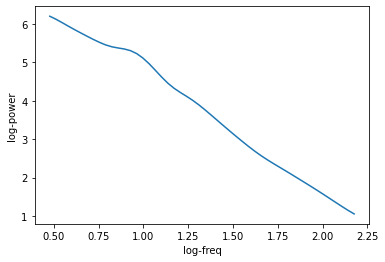

In [6]:
##### Load EEG
from CMLLoad import CMLLoad

# Remember to update this to where your CMLExamples data is located.
load = CMLLoad('./CMLExamples')

# We load the dataframe for all sessions.
df = load.Index()

buf = 1000  #define the buffer (in ms) here. Should be at least half the total wavelet length at lowest frequency (i.e. 1/2f * n_cycles). With standard params, 1 sec usually suffices. 

# We load the dataframe for all sessions.
df = load.Index()

# Specify which subject and experiment we want
sub = 'R1111M'
exp = 'FR1'

# Select the dataframes for our subject and experiment.
df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
# Pick the first session
df_sess = df_select.iloc[0]

# For first session...
evs = load.Load(df_sess, 'events')
word_evs = evs[evs['type']=='WORD']

# Load the EEG as an mne object.
eeg = load.LoadMNE(df_sess, ev_start=-buf, ev_len=buf+1000+buf)
# Select all word events.
eeg = eeg[word_evs.index]
# Select the 62nd electrode.
eeg = eeg.pick_channels(eeg.ch_names[62:63])

sr = eeg.info['sfreq'] #we'll need this soon

# Pre-define an array of frequencies.
# We can log-space them since wavelets are less sensitive to differences at higher frequencies
myfreqs = np.logspace(np.log10(3), np.log10(150), num=50)

# Run TF decomposition
# We're setting it to automatically average across trials
power = mne.time_frequency.tfr_morlet(eeg, freqs=myfreqs, n_cycles=5, return_itc=False, average=True)
log_power = np.log10(power.data[0, :, int(buf/1000.*sr):-1*int(buf/1000.*sr)])
log_power = log_power.mean(axis = 1)
log_freqs = np.log10(power.freqs)


plt.plot(log_freqs, log_power)
plt.xlabel('log-freq')
plt.ylabel('log-power')

Text(1.75, 8, 'y =7.99-3.2*x')

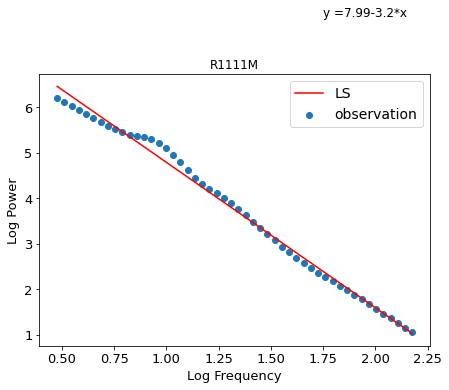

In [7]:
# Fit model using linear_model from sklearn
from sklearn import linear_model
reg = linear_model.LinearRegression()

data = pd.DataFrame({'log_pow':log_power, 'log_frequency': log_freqs})

X = data['log_frequency'].values.reshape((len(data['log_pow']),1))
y = data['log_pow'].values
model = reg.fit(X, y)
b_est = model.coef_[0]
alpha_est = model.intercept_


fig = plt.figure(figsize = (7,5))
ax = plt.subplot(111)
ax.scatter(X,y, label = 'observation')
ax.plot(X, alpha_est + b_est*X, color = 'red', label = 'LS')
ax.legend(fontsize =14)

ax.tick_params(labelsize = 13)
ax.set_xlabel('Log Frequency', fontsize = 13)
ax.set_ylabel('Log Power', fontsize = 13)
ax.set_title('R1111M')
ax.text(1.75,8,'y =' + str(round(alpha_est,2)) + str(round(b_est,2)) + '*x' ,size=12)

In [8]:
# Fit using statsmodels
from statsmodels.formula.api import ols
model = ols("log_pow ~ log_frequency", data).fit()
# get model parameters
print(model.params)
print(model.summary())
# dir(model)

Intercept        7.991609
log_frequency   -3.201149
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                log_pow   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     6680.
Date:                Tue, 11 Aug 2020   Prob (F-statistic):           3.47e-53
Time:                        13:10:25   Log-Likelihood:                 28.892
No. Observations:                  50   AIC:                            -53.78
Df Residuals:                      48   BIC:                            -49.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [9]:
# Get all the good stuffs
mse_model = model.mse_model
mse_resid = model.mse_resid
mse_total = model.mse_total
df_model = model.df_model
df_resid = model.df_resid
df_total = model.nobs -1

# get sum of squares
tss = mse_total*df_total
rss = mse_resid*df_resid
mss = mse_model*df_model
tss == mss + rss

True

In [10]:
# Hypothesis testing 
# f_test

F_stat = mse_model/mse_resid # calculate by  hand
print(F_stat)

hypothesis= '(log_frequency=0)'
model.f_test(hypothesis)

6680.265534266779


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[6680.26553427]]), p=3.4726795956339647e-53, df_denom=48, df_num=1>

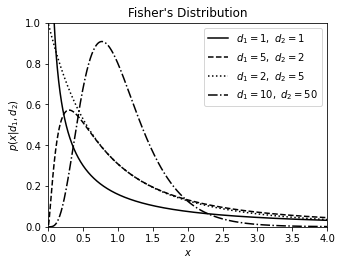

In [11]:
# Example of F-distributions with different degrees of freedom
from scipy.stats import f as fisher_f
mu = 0
d1_values = [1, 5, 2, 10]
d2_values = [1, 2, 5, 50]
linestyles = ['-', '--', ':', '-.']
x = np.linspace(0, 5, 1001)[1:]

fig, ax = plt.subplots(figsize=(5, 3.75))

for (d1, d2, ls) in zip(d1_values, d2_values, linestyles):
    dist = fisher_f(d1, d2, mu)

    plt.plot(x, dist.pdf(x), ls=ls, c='black',
             label=r'$d_1=%i,\ d_2=%i$' % (d1, d2))

plt.xlim(0, 4)
plt.ylim(0.0, 1.0)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|d_1, d_2)$')
plt.title("Fisher's Distribution")

plt.legend()
plt.show()

In [12]:
# Partial F-tests 
# Create other variables
data.shape
data['var1'] = np.random.normal(0,1, data.shape[0]) # random normals
data['var2'] = np.random.normal(0,3,data.shape[0])
data['var3'] = np.random.normal(2,3,data.shape[0])
model = ols("log_pow ~ log_frequency + var1 + var2 + var3", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_pow   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1584.
Date:                Tue, 11 Aug 2020   Prob (F-statistic):           8.98e-48
Time:                        13:10:25   Log-Likelihood:                 29.186
No. Observations:                  50   AIC:                            -48.37
Df Residuals:                      45   BIC:                            -38.81
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.9959      0.061    131.419

In [13]:
# Test if var1 = var2 = var3 = 0 
R= [[0,0,1,1,1]]
model.f_test(R)
hypotheses = '(var1=0), (var2=0), (var3=0)'
print(model.f_test(hypotheses))

#Do this by hand 
# reduced model 
model_reduced = ols("log_pow ~ log_frequency", data).fit()
# full model
model_full = ols("log_pow ~ log_frequency + var1 + var2 + var3", data).fit()

# get Residual Sum of Squares (RSS)
RSS_reduced = model_reduced.ssr
RSS_full = model_full.ssr
F_partial = ((RSS_reduced - RSS_full)/(model_reduced.df_resid - model_full.df_resid))/(RSS_full/model_full.df_resid)
df_num = model_reduced.df_resid - model_full.df_resid
df_denom = model_full.df_resid
print (F_partial)
print ('df_num = ',  df_num)
print ('df_denom =', df_denom)

# import the f distribution
from scipy.stats import f
print('p_val= ', 1-f.cdf(F_partial, dfn = df_num, dfd = df_denom))
# Fail to reject the null 
# var1, var2, var3 are collectively useless (informal conclusion of course)

<F test: F=array([[0.17781972]]), p=0.9108795453217774, df_denom=45, df_num=3>
0.1778197195233527
df_num =  3.0
df_denom = 45.0
p_val=  0.9108795453217846


95% CI boot:  (99.85233976029922, 100.25435587888619)
95% CI wald:  (99.85660517410224, 100.25009046508316)


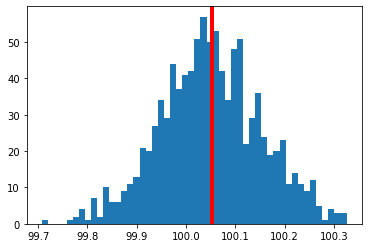

In [14]:
# Bootstrap Example 
N = 10000
original_sample = np.random.normal(100,10,N)
original_sample_mean = np.mean(original_sample)

B = 1000
boot_means = np.zeros(B)

# create bootstrapped sample means
for b in np.arange(B): 
    indices_b = np.random.choice(range(0, N),N)
    boot_sample = original_sample[indices_b]
    boot_means[b] = np.mean(boot_sample)

plt.hist(boot_means, bins = 50)
plt.axvline(np.mean(original_sample), color = 'red', lw = 4)

# bootstrap standard error
se_boot = np.std(boot_means)
CI_boot = (original_sample_mean - 1.96*se_boot, original_sample_mean + 1.96*se_boot)
# wald standard error
se_parametric = np.std(original_sample)/np.sqrt(N)
CI = (original_sample_mean - 1.96*se_parametric, original_sample_mean + 1.96*se_parametric)
print ('95% CI boot: ', CI_boot)
print  ('95% CI wald: ', CI)


In [15]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

X = data['log_frequency'].values.reshape((len(data['log_pow']),1))
y = data['log_pow'].values

model = reg.fit(X, y)
b_est = model.coef_
print(b_est)

[-3.20114941]


In [16]:
# Bootstrap confidence intervals
N = data.shape[0]
print(N)
B = 10000
b_boot_obs = np.zeros(B)
b_boot_resid = np.zeros(B)

y_hat = model.predict(X)
resid = y - y_hat

for b in np.arange(B):
    indices_b = np.random.choice(range(0, N),N)
    #observation resampling
    y_b = y[indices_b]
    X_b = X[indices_b,:]
    model = reg.fit(X_b,y_b)
    b_boot_obs[b] = model.coef_
    # residual resampling
    resid_b = resid[indices_b]
    y_b = y_hat + resid_b
    model = reg.fit(X, y_b)
    b_boot_resid[b] = model.coef_

    

50


In [17]:
print(np.mean(b_boot_obs), np.mean(b_boot_resid))
print(np.std(b_boot_obs), np.std(b_boot_resid))

-3.204618700398524 -3.2013612045838173
0.041874907387512546 0.037887315841539475


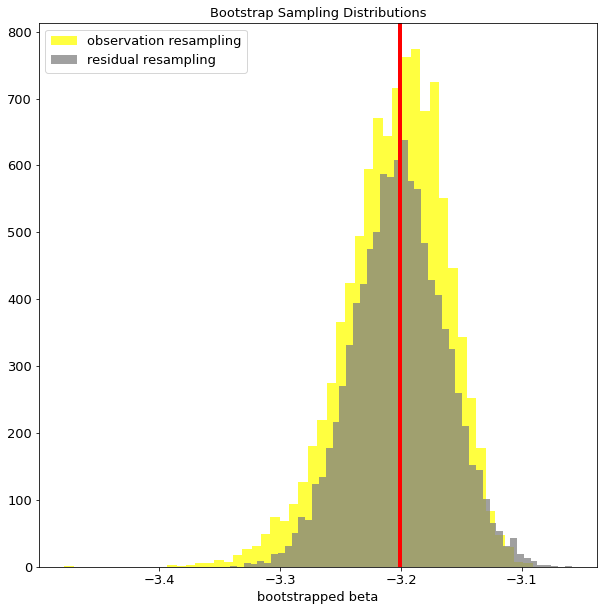

In [18]:
fig = plt.figure(figsize = (10,10))
ax = plt.subplot(111)
ax.hist(b_boot_obs, label = 'observation resampling', facecolor = 'yellow', alpha = 0.75, bins = 50)
ax.hist(b_boot_resid, label = 'residual resampling', facecolor = 'grey', alpha = 0.75, bins = 50)
ax.axvline(x = b_est, color = 'red', lw = 4)

ax.tick_params(labelsize = 13)
ax.set_xlabel('bootstrapped beta', fontsize = 13)
ax.set_ylabel('', fontsize = 13)
ax.set_title('Bootstrap Sampling Distributions', fontsize = 13)
ax.legend(fontsize =13)

sd_boot_obs = np.std(b_boot_obs)
sd_boot_resid = np.std(b_boot_resid)


# Assignment 5
In this assignment, you will estimate the exponent of the power law for more electrodes in R1111M. 
1. Select the first 50 electrodes and computes spectral power using Morlet wavelets for 30 frequencies between 3 and 150 Hz (np.logspace(np.log10(3), np.log10(150), num=30)) using buf = 1000 ms. 
2. Fit a regression of $\log(power) \sim \log(freq)$ for each electrode and obtain an estimate for $\alpha$, where $\alpha$ is the exponent in $ power \sim 1/freq^\alpha$.
3. Plot the distribution of $\alpha$ across these 50 electrodes. How consistent are the $\alpha$'s across these electrodes? 

In [19]:
##### Load EEG
import mne
import numpy as np
from CMLLoad import CMLLoad

# Remember to update this to where your CMLExamples data is located.
load = CMLLoad('./CMLExamples')

# We load the dataframe for all sessions.
df = load.Index()

buf = 1000  #define the buffer (in ms) here. Should be at least half the total wavelet length at lowest frequency (i.e. 1/2f * n_cycles). With standard params, 1 sec usually suffices. 

# We load the dataframe for all sessions.
df = load.Index()

# Specify which subject and experiment we want
sub = 'R1111M'
exp = 'FR1'

# Select the dataframes for our subject and experiment.
df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
# Pick the first session
df_sess = df_select.iloc[0]

# For first session...
evs = load.Load(df_sess, 'events')
word_evs = evs[evs['type']=='WORD']

# Load the EEG as an mne object.
eeg = load.LoadMNE(df_sess, ev_start=-buf, ev_len=buf+1000+buf)
# Select all word events.
eeg = eeg[word_evs.index]
# Select the 62nd electrode.
eeg = eeg.pick_channels(eeg.ch_names[:50])

sr = eeg.info['sfreq'] #we'll need this soon

# Pre-define an array of frequencies.
# We can log-space them since wavelets are less sensitive to differences at higher frequencies
myfreqs = np.logspace(np.log10(3), np.log10(150), num=30)

# Run TF decomposition
# We're setting it to automatically average across trials
power = mne.time_frequency.tfr_morlet(eeg, freqs=myfreqs, n_cycles=5, return_itc=False, average=True)

765 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [20]:
log_power = np.log10(power.data[:, :, int(buf/1000.*sr):-1*int(buf/1000.*sr)]).mean(axis=2, keepdims=True)
log_freqs = np.log10(power.freqs)
log_power.shape

(50, 30, 1)

In [21]:
from sklearn import linear_model

b_est = []
for ch_power in log_power:
    reg = linear_model.LinearRegression()
    reg.fit(ch_power, log_freqs)
    b_est.append(reg.coef_[0])

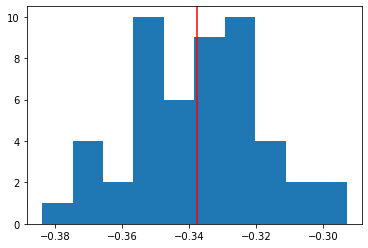

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(b_est)
plt.axvline(x=np.mean(b_est), color='red')